In [1]:
%cd ..
import os
import time
import json

/home/yongming/apperception


In [2]:
from apperception.database import database
from apperception.world import empty_world
from apperception.utils import F
from apperception.predicate import camera, objects
from optimized_ingestion.utils.preprocess import preprocess
database.connection
from optimized_ingestion.cache import disable_cache
disable_cache()

CUDA is not available.


In [3]:
NUSCENES_PROCESSED_DATA = "NUSCENES_PROCESSED_DATA"
if NUSCENES_PROCESSED_DATA in os.environ:
    DATA_DIR = os.environ[NUSCENES_PROCESSED_DATA]
else:
    DATA_DIR = "/data/processed/full-dataset/trainval"
NUSCENES_RAW_DATA = "NUSCENES_RAW_DATA"
if NUSCENES_RAW_DATA in os.environ:
    RAW_DATA_DIR = os.environ[NUSCENES_RAW_DATA]
else:
    RAW_DATA_DIR = "/data/full-dataset/trainval"

In [4]:
with open('data/evaluation/video-samples/boston-seaport.txt', 'r') as f:
    scenes = f.read().split('\n')

In [5]:
def bechmark_detection_estimation_gain(world,video_names=[], scenes=[], path_suffix=None):
    base_benchmark_path = f'./outputs/base_pipeline_benchmark{"_"+path_suffix if path_suffix else ""}.json'
    ### base pipeline
    preprocess(world, DATA_DIR, video_names, scenes,
               benchmark_path=base_benchmark_path)
    ### detection estimation benchmark
    for skip_ratio in [0.1 * i for i in range(1,10)]:
        print(f"current skip ratio{skip_ratio}")
        optimize_benchmark_path = f'./outputs/detection_estimation_pipeline_{int(skip_ratio*10)}{"_"+path_suffix if path_suffix else ""}.json'
        preprocess(world, DATA_DIR, video_names,
                   base=False,
                   benchmark_path=optimize_benchmark_path,
                   skip_ratio=skip_ratio)
    

In [6]:
name = 'ScenicWorld' # world name
world = empty_world(name=name)

In [ ]:
bechmark_detection_estimation_gain(world, scenes=scenes[:200])

In [ ]:
subprocess.Popen('shutdown -h now', shell=True)

In [ ]:
obj1 = objects[0]
cam = camera
car_world = empty_world(name=name).filter(
    (F.like(obj1.type, 'car') | F.like(obj1.type, 'truck') | F.like(obj1.type, 'bus'))
)

In [ ]:
bechmark_detection_estimation_gain(car_world, scenes=scenes[:200], path_suffix="only_car")

In [9]:
with open('./outputs/base_pipeline_benchmark_only_car.json') as benchmark_file:
    benchmark_content = benchmark_file.read()

parsed_json = json.loads(benchmark_content)
baseline_total_runtime = parsed_json[0]['total_runtime']
baseline_avg_runtime = parsed_json[1]['average runtime']
baseline_stage_runtimes = parsed_json[0]['stage_runtimes']
for stage_runtime in baseline_stage_runtimes:
    if stage_runtime['stage'] == 'Tracking2D.StrongSORT':
        baseline_strong_sort_runtime = sum([r['runtime'] for r in stage_runtime['runtimes']])

num_videos = parsed_json[2]['number of videos']
print(baseline_total_runtime)
print(baseline_avg_runtime)
print(baseline_strong_sort_runtime)

44513.41584300995
74.18902640501658
21762.033635139465


In [10]:
skip_ratios = [i for i in range(1, 10)]
# all_obj_total_runtimes = []
# all_obj_avg_runtimes = []
# all_obj_strong_sort_runtimes = []
only_car_total_runtimes = []
only_car_avg_runtimes = []
only_car_strong_sort_runtimes = []
for i in skip_ratios:
#     with open(f'./outputs/detection_estimation_pipeline_{i}.json') as benchmark_file:
#         benchmark_content = benchmark_file.read()

#     parsed_json = json.loads(benchmark_content)
#     all_obj_total_runtimes.append(parsed_json[0]['total_runtime'])
#     all_obj_avg_runtimes.append(parsed_json[1]['average runtime'])
#     all_obj_stage_runtimes = parsed_json[0]['stage_runtimes']
#     for stage_runtime in all_obj_stage_runtimes:
#         if stage_runtime['stage'] == 'Tracking2D.StrongSORT':
#             all_obj_strong_sort_runtimes.append(sum([r['runtime'] for r in stage_runtime['runtimes']]))

    with open(f'./outputs/detection_estimation_pipeline_{i}_only_car.json') as benchmark_file:
        benchmark_content = benchmark_file.read()

    parsed_json = json.loads(benchmark_content)
    only_car_total_runtimes.append(parsed_json[0]['total_runtime'])
    only_car_avg_runtimes.append(parsed_json[1]['average runtime'])
    only_car_stage_runetimes = parsed_json[0]['stage_runtimes']
    for stage_runtime in only_car_stage_runetimes:
        if stage_runtime['stage'] == 'Tracking2D.StrongSORT':
            only_car_strong_sort_runtimes.append(sum([r['runtime'] for r in stage_runtime['runtimes']]))

# print(all_obj_total_runtimes)
# print(all_obj_avg_runtimes)
print(only_car_total_runtimes)
print(only_car_avg_runtimes)
# print(all_obj_strong_sort_runtimes)
print(only_car_strong_sort_runtimes)

[41446.81007170677, 40285.96972346306, 38539.26634144783, 36501.06166219711, 34673.08903479576, 32426.21813392639, 30521.662829875946, 29123.23873615265, 24960.783925771713]
[69.07801678617795, 67.14328287243843, 64.23211056907972, 60.83510277032852, 57.788481724659604, 54.04369688987732, 50.869438049793246, 48.53873122692108, 41.601306542952855]
[15140.731721878052, 14194.618133544922, 12994.322679281235, 11634.632242679596, 10432.16951417923, 9057.24088358879, 7693.205211162567, 6370.851288318634, 4610.894718408585]


number of videos 600


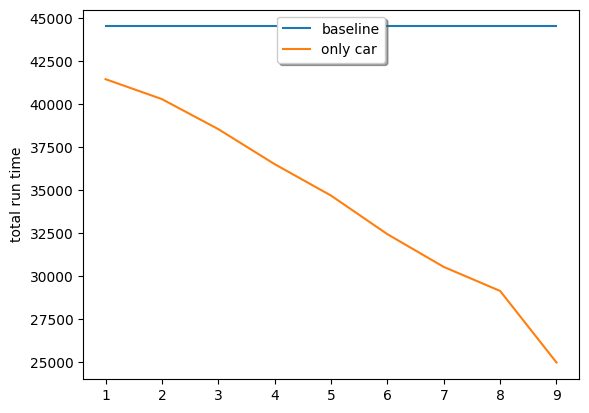

In [11]:
import matplotlib.pyplot as plt
print(f'number of videos {num_videos}')
fig, ax = plt.subplots()
ax.plot(skip_ratios, len(skip_ratios)*[baseline_total_runtime], label='baseline')
# ax.plot(skip_ratios, all_obj_total_runtimes, label='all obj')
ax.plot(skip_ratios, only_car_total_runtimes, label='only car')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('total run time')
plt.show()

number of videos 600


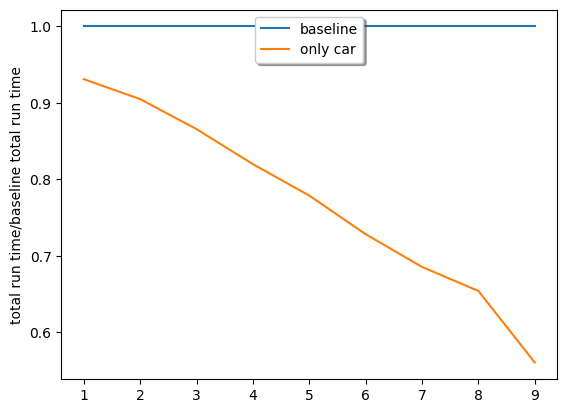

In [12]:
import matplotlib.pyplot as plt
print(f'number of videos {num_videos}')
fig, ax = plt.subplots()
ax.plot(skip_ratios, len(skip_ratios)*[baseline_total_runtime/baseline_total_runtime], label='baseline')
# ax.plot(skip_ratios, [e/baseline_total_runtime for e in all_obj_total_runtimes], label='all obj')
ax.plot(skip_ratios, [e/baseline_total_runtime for e in only_car_total_runtimes], label='only car')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('total run time/baseline total run time')
plt.show()

number of videos 600


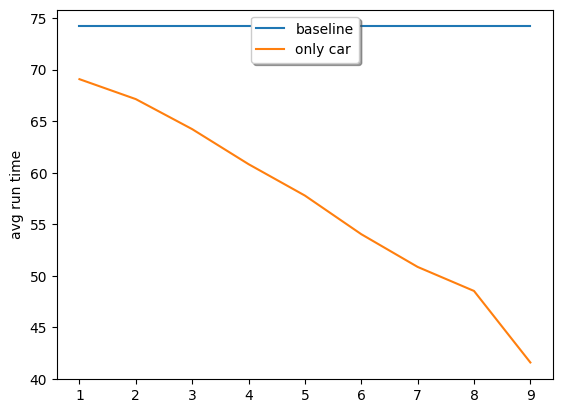

In [13]:
import matplotlib.pyplot as plt
print(f'number of videos {num_videos}')
fig, ax = plt.subplots()
ax.plot(skip_ratios, len(skip_ratios)*[baseline_avg_runtime], label='baseline')
# ax.plot(skip_ratios, all_obj_avg_runtimes, label='all obj')
ax.plot(skip_ratios, only_car_avg_runtimes, label='only car')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('avg run time')
plt.show()

number of videos 600


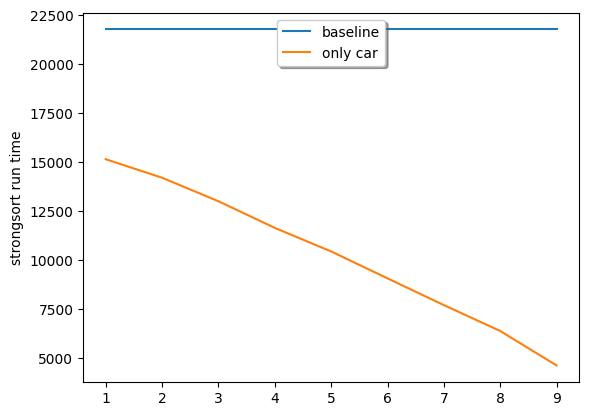

In [14]:
import matplotlib.pyplot as plt
print(f'number of videos {num_videos}')
fig, ax = plt.subplots()
ax.plot(skip_ratios, len(skip_ratios)*[baseline_strong_sort_runtime], label='baseline')
# ax.plot(skip_ratios, all_obj_strong_sort_runtime, label='all obj')
ax.plot(skip_ratios, only_car_strong_sort_runtimes, label='only car')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('strongsort run time')
plt.show()

number of videos 600


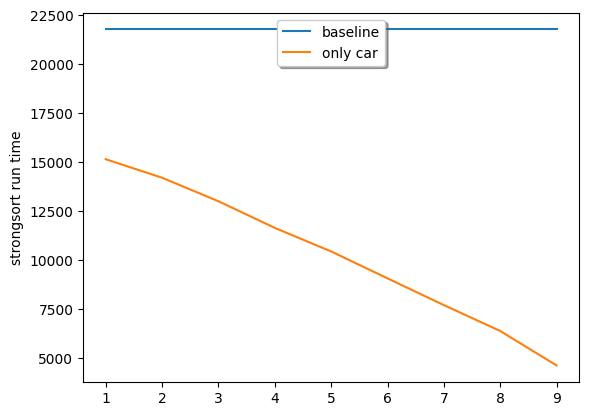

In [15]:
import matplotlib.pyplot as plt
print(f'number of videos {num_videos}')
fig, ax = plt.subplots()
ax.plot(skip_ratios, len(skip_ratios)*[baseline_strong_sort_runtime], label='baseline')
# ax.plot(skip_ratios, all_obj_strong_sort_runtime, label='all obj')
ax.plot(skip_ratios, only_car_strong_sort_runtimes, label='only car')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('strongsort run time')
plt.show()